In [33]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import pickle
import seaborn as sns
import scipy
import statistics as stats
from copy import copy
from ete3 import Tree
from copy import copy

In [3]:
sc.settings.verbosity = 0
sc.settings.figdir = '/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/scRNA/figures/'

In [34]:
clusterColorsFile = "/Genomics/chanlab/mchan/Adriano/TLS/TLS_TLSCL/20211102_clusterColorsTLSCL.p"
with open(clusterColorsFile,'rb') as fp:
    colorDict = pickle.load(fp)
    
Greens = copy(mpl.cm.Greens)
Greens.set_under("lightgray")
Reds = copy(mpl.cm.Reds)
Reds.set_under("lightgray")

In [5]:
# Load AM-DNA-097 scanpy object
TLS1 = sc.read_h5ad('/Genomics/chanlab/blaw/TLS/raw_data/scRNA/TLS12/TLS_120h_1.h5ad')
# Load the TLS timecourse scanpy object
TLS_integrated = sc.read_h5ad('/Genomics/chanlab/blaw/TLS/raw_data/scRNA/TLS12/TLS.integrated.h5ad')

In [6]:
# Load the TLS1 tree
TLS1_loc = '/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/2_lineage_reconstruction/AM-DNA-097_hybrid_newick_noMutationlessEdges_Labeled.nwk'
t = Tree(TLS1_loc, format=1)

In [7]:
# Load the allele table and lineage table
allele_table = pd.read_csv("/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/2_lineage_reconstruction/allele_table_filtered.txt", sep = '\t')
lineage_table = pd.read_csv("/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/2_lineage_reconstruction/AM-DNA-097_lineage_table.txt", sep = '\t')

# UMAPs of Marker Genes

... storing 'orig.ident' as categorical
... storing 'integrated_snn_res.0.5' as categorical
... storing 'seurat_clusters' as categorical
... storing 'BC' as categorical
... storing 'Phase' as categorical
... storing 'old.ident' as categorical
... storing 'integrated_snn_res.0.8' as categorical
... storing 'cluster' as categorical
... storing 'cell_state' as categorical
... storing 'predicted.id' as categorical


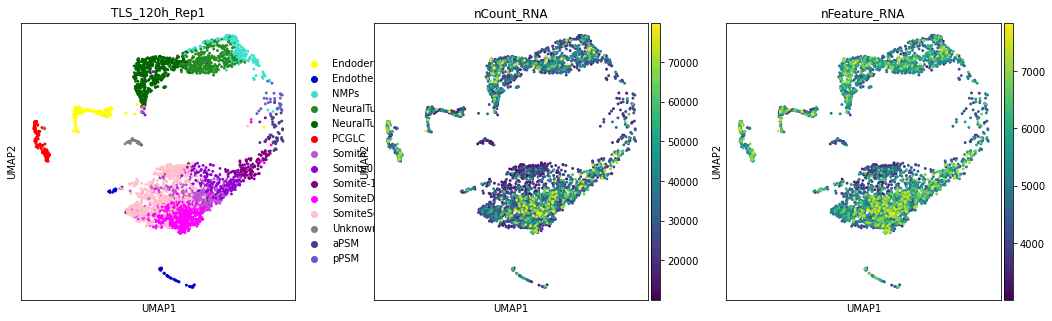

In [8]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(TLS1, color=['cell_state', 'nCount_RNA', 'nFeature_RNA'], title='TLS_120h_Rep1', palette = colorDict, save = '_TLS1_scRNA_QC.pdf')

In [9]:
genes = ['Sox3', 'Meox2', 'Cdx2', 'Tbx6', 'Ripply2', 'Kdr', 'Foxa2', 'Dppa3', 'Cer1', 'Pax6', 'Dbx1', 'Pax3', 'Pax1', 'Sox9',
         'Tcf15', 'Meox1']

In [10]:
for gene in genes:
    with rc_context({'figure.figsize': (5, 5)}):
        sc.pl.umap(TLS1, color=gene, title='TLS_120h_1_' + gene, use_raw = False, save = '_TLS1_' + gene + '.pdf', show = False, cmap=reds)

# Composition of TLS1 vs 120h of the Timecourse

In [11]:
TLS_120h = TLS_integrated[TLS_integrated.obs['orig.ident'].isin(['mGast_120h'])]

In [12]:
TLS1_cell_states_percent = {}
TLS_120h_cell_states_percent = {}

for cell_state in colorDict.keys():
    TLS1_cell_states_percent[cell_state] = 100 * len(TLS1[TLS1.obs['cell_state'] == cell_state]) / len(TLS1) 
    TLS_120h_cell_states_percent[cell_state] = 100 * len(TLS_120h[TLS_120h.obs['cell_state'] == cell_state]) / len(TLS_120h)

In [13]:
cell_percents = pd.DataFrame.from_dict([TLS_120h_cell_states_percent, TLS1_cell_states_percent])
cell_percents = cell_percents.rename(index = {0: "TLS_120h", 1: "TLS1"})

In [15]:
colors = []
for color in cell_percents.columns:
    colors.append(colorDict[color])
    
cell_percents.plot(kind='bar', use_index = True, stacked=True, color = colors, grid = False, figsize = (2, 2))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), prop={'size': 5})
plt.title('cell_state_proportions')
plt.ylabel('% cells/cluster')
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/scRNA/figures/TLS_1_vs_Timecourse_Cell_Percents.pdf', dpi = 300)
#plt.show()
plt.close()

# Overlay Desired Nodes onto TLS1 UMAP

In [16]:
# create a dictionary for the leaves in each selected node
node_dict = {}
selected_nodes = ['node1', 'node40', 'node150', 'node431', 'node534', 'node638', 'node640', 'node435', 'node42', 'node153']
for node in t.traverse():
    if node.name in selected_nodes:
        node_dict[node.name] = [leaf.name for leaf in node.get_leaves()]

In [17]:
for node in node_dict.keys():
    test = node_dict[node]
    cell_states = {}

    for state in colorDict.keys():
        cell_states[state] = 0

    for cell in test:
        cell_state = TLS1.obs.loc['TLS_120h_rep1_' + cell]['cell_state']
        cell_states[cell_state] += 1
        
    sorted_cell_states = {k: v for k, v in sorted(cell_states.items(), key=lambda item: item[1])}
    
    labels = sorted_cell_states.keys()
    sizes = sorted_cell_states.values()

    colors = []
    for label in labels:
        colors.append(colorDict[label])

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors = colors, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(node + ' - ' + str(len(test)) + ' Cells')
    plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/scRNA/node_pies/' + node + '_composition_pie.pdf', dpi = 300)
    #plt.show()
    plt.close()

In [18]:
for ID in node_dict.keys():
    TLS1_node_ID = TLS1[['TLS_120h_rep1_' + s for s in node_dict[ID]]].copy()
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    plt.plot(TLS1.obsm['X_umap'][:,0], TLS1.obsm['X_umap'][:,1], '.', color= "lightgray", alpha = 0.8, ms = 5, rasterized = True, markeredgewidth = 0.0)
    for cell_state in colorDict.keys():
        TLS1_node_ID_cell_state = TLS1_node_ID[TLS1_node_ID.obs['cell_state'] == cell_state].copy()
        plt.plot(TLS1_node_ID_cell_state.obsm['X_umap'][:,0], TLS1_node_ID_cell_state.obsm['X_umap'][:,1], '.', alpha = 1, ms = 10, color = colorDict[cell_state], markeredgewidth = 0.0)
    plt.axis([-15, 11, -15, 11])
    ax.set_yticks([])
    ax.set_xticks([])
    plt.title(str(ID) + " - " + str(len(node_dict[ID])) + ' Cells')
    plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/scRNA/node_umaps/' + str(ID) + '_umap_Overlay.pdf', dpi = 900)
    #plt.show()
    plt.close()

# QC of Target and Cut Sites in the scRNA seq

In [19]:
lineage_table

,cellBC,CTTAATTCGCATTT_r1,CTTAATTCGCATTT_r2,CTTAATTCGCATTT_r3,AACTATTACATATA_r1,AACTATTACATATA_r2,AACTATTACATATA_r3,GTCAGAACTTCTCC_r1,GTCAGAACTTCTCC_r2,GTCAGAACTTCTCC_r3,...,ATCCGACTTATATC_r3,TAACTTTTGAGACA_r1,TAACTTTTGAGACA_r2,TAACTTTTGAGACA_r3,TCTTCAATAGTTTT_r1,TCTTCAATAGTTTT_r2,TCTTCAATAGTTTT_r3,TGAGTGTAACACTG_r1,TGAGTGTAACACTG_r2,TGAGTGTAACACTG_r3
0,AAACCCACACTACCGG-1,[None],[None],[None],[None],[None],[None],[None],[158:22D],[None],...,[None],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAACCCAGTAGCACGA-1,[None],[None],[None],[None],[None],[None],[None],[None],[None],...,[None],[None],[None],[None],NaN,NaN,NaN,NaN,NaN,NaN
2,AAACCCAGTCAACACT-1,[None],[164:18D],[None],[None],[None],[None],[None],[None],[None],...,[None],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAACCCATCATGAAAG-1,[None],[None],[None],[None],[None],[None],[None],[None],[None],...,[None],[None],[None],[None],NaN,NaN,NaN,NaN,NaN,NaN
4,AAACGAAAGGAATCGC-1,[None],[None],[None],[None],[None],[None],[None],[None],[None],...,[None],[None],[None],[None],NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3205,TTTGGTTTCATGCGGC-1,[None],[None],[None],[None],[165:25D],[None],[None],[169:9I]ACTGGTTCA,[None],...,[None],[None],[None],[None],NaN,NaN,NaN,NaN,NaN,NaN
3206,TTTGGTTTCGTTGTAG-1,[None],[None],[None],[None],[None],[None],[None],[155:19D],[None],...,[None],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3207,TTTGGTTTCTCGTGGG-1,[None],[None],[None],[None],[None],[None],[None],[None],[None],...,[None],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3208,TTTGTTGAGAGCATAT-1,[None],[None],[None],[99:76D],[99:76D],[None],[117:1D],[173:1D],[233:13I]CGCGGAGGACAAT,...,[None],NaN,NaN,NaN,[None],[164:18D],[None],NaN,NaN,NaN


In [20]:
lineage_table["cellBC1"] = "TLS_120h_rep1_" + lineage_table["cellBC"]
lineage_table.set_index("cellBC1", inplace = True)
lineage_table.drop("cellBC", axis = 1, inplace = True)
n = lineage_table.shape[0]

In [27]:
aColNames = lineage_table.columns[range(0, lineage_table.shape[1], 3)].tolist()

In [25]:
mask = lineage_table[aColNames].isnull() == False
maskSum = mask.sum(axis = 0)

maskSum1 = maskSum / lineage_table.shape[0]
ms = maskSum1.sort_values(ascending = False)
aIntBCs = [i.split("_")[0] for i in ms.index.tolist()]

h = plt.figure(figsize = (4, 4))
plt.bar(np.arange(10), ms)
plt.ylim([0, 1.05])
plt.ylabel("fraction tS")
plt.xlabel("target site")
plt.title("AM-DNA-097_TLS1")
plt.xticks([i for i in range(len(aIntBCs))], aIntBCs, rotation = 90)
plt.subplots_adjust(left = 0.2, bottom = 0.5)
plt.savefig("/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/AM-DNA-097_tSCapture.pdf", dpi = 300)
#plt.show()
plt.close()

In [28]:
aIntBCs_cutSites = [i + j for i in aIntBCs for j in ["_r1","_r2","_r3"] ]

In [31]:
# indel histograms
maskNA = lineage_table[aIntBCs_cutSites].isnull() == True
maskNASum = maskNA.sum(axis = 0)
maskNone = lineage_table[aIntBCs_cutSites] == "[None]"
maskNoneSum = maskNone.sum(axis = 0)
maskMiss = lineage_table[aIntBCs_cutSites] == "Missing"
maskMissSum = maskMiss.sum(axis = 0)
maskTotal1 = maskNASum + maskNoneSum + maskMissSum
maskCutSum = lineage_table.shape[0] - maskTotal1

l = []
x = 0
for i in np.arange(1, len(maskMissSum) + 1):
    l.append(x)
    x = x + 1
    if i % 3 == 0:
        x = x + 1

h = plt.figure(figsize = (8,5))
ax = plt.subplot(1, 1, 1)
plt.bar(l, maskCutSum, 0.75, label ="Cut", color = "Red")
plt.bar(l, maskNoneSum, 0.75, bottom = maskCutSum + maskMissSum, label = "NoCut", color = "Grey")
plt.bar(l, maskMissSum, 0.75, bottom = maskCutSum, label = "Missing", color = "Blue")
x1 = plt.xticks(l, aIntBCs_cutSites, rotation = 90, fontsize = 8)
plt.ylabel("# cells")
plt.legend(loc = "upper right")

plt.subplots_adjust(left = 0.1, bottom = 0.3)
plt.savefig("/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/AM-DNA-097_Cut_Site_Capture.pdf", dpi = 300)
#plt.show()
plt.close()

In [35]:
maskPresent = lineage_table[aIntBCs_cutSites].isnull() == False
maskPresentSum = maskPresent.sum(axis = 1)
maskNone = lineage_table[aIntBCs_cutSites] == "[None]"
maskNoneSum = maskNone.sum(axis = 1)
maskMiss = lineage_table[aIntBCs_cutSites] == "Missing"
maskMissSum = maskMiss.sum(axis = 1)
maskCutSum = maskPresentSum - maskNoneSum - maskMissSum

pctCut = maskCutSum / maskPresentSum
#pctCut[0:10]

In [36]:
TLS1.obs = pd.concat([TLS1.obs, pctCut], axis = 1)
TLS1.obs.rename(columns={0: "pctCut"}, inplace = True)

In [38]:
mask = lineage_table[aColNames].isnull() == False
maskSum = mask.sum(axis = 1)
TLS1.obs["numTargetSites"] = maskSum.loc[maskSum.index]

mask = (lineage_table.isnull() == False) & (lineage_table !="[None]") & (lineage_table != "Missing")
maskSum = mask.sum(axis = 1)
TLS1.obs["numIndels"] = maskSum.loc[maskSum.index]

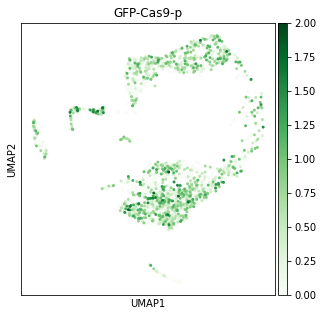

In [42]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(TLS1, color=['GFP-Cas9-p'], cmap = Greens, use_raw = False, vmin = 0, vmax = 2, legend_loc = None, 
               save = 'GFP_Expression_per_Cell.pdf')

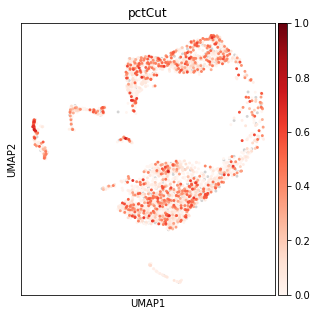

In [44]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(TLS1, color='pctCut', cmap = Reds, use_raw = False, vmin = 0, vmax = 1, save = 'Percent_Cut_per_Cell.pdf')

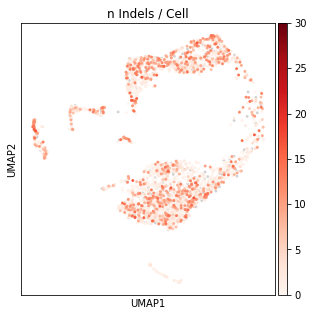

In [46]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(TLS1, color='numIndels', title = 'n Indels / Cell', cmap = Reds, use_raw = False, vmin = 0, vmax = 30,
               save = 'Indels_per_Cell.pdf')

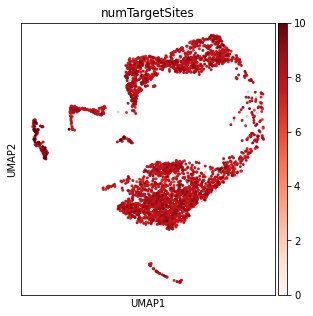

In [47]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(TLS1, color='numTargetSites', cmap = Reds, use_raw = False, vmin = 0, vmax = 10,
               save = 'n_Target_Sites_per_Cell.pdf')

# Histograms of Tree Metrics

In [49]:
GFP_expr = TLS1.X[:,21473]
GFP_expr = GFP_expr.todense()

In [50]:
# Add GFP positive and pctCut positive columns
TLS1.obs['GFP-Cas9-p'] = GFP_expr
TLS1.obs["GFP_pos"] = 0
x1 = TLS1.obs[TLS1.obs["GFP-Cas9-p"] > 0].index.tolist()
TLS1.obs.loc[x1, "GFP_pos"] = 1

TLS1.obs["pctCut_pos"] = 0
x1 = TLS1.obs[TLS1.obs["pctCut"] > 0].index.tolist()
TLS1.obs.loc[x1,"pctCut_pos"] = 1

In [52]:
len(TLS1.obs[TLS1.obs['GFP_pos'] == 1]) / len(TLS1.obs)

0.3413474979032709

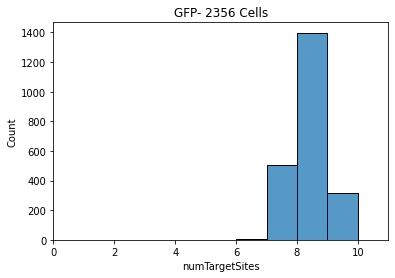

In [55]:
fig = plt.subplots
ax1 = sns.histplot(data = TLS1.obs[TLS1.obs['GFP_pos'] == 0], x = 'numTargetSites', binwidth = 1, bins = 10)
ax1.set_xlim(0, 11)
ax1.set_xticks([0, 2, 4, 6, 8, 10])
ax1.grid(False)
ax1.set_title('GFP- {} Cells'.format(len(TLS1.obs[TLS1.obs['GFP_pos'] == 0])))

plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/n_target_sites_GFP-_hist.pdf', dpi = 300)
plt.show()
plt.close()

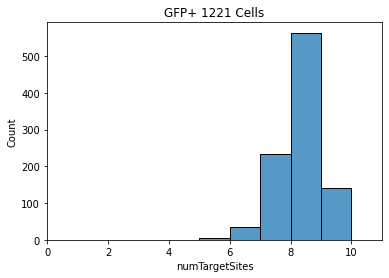

In [57]:
fig = plt.subplots
ax1 = sns.histplot(data = TLS1.obs[TLS1.obs['GFP_pos'] == 1], x = 'numTargetSites', binwidth = 1, bins = 10)
ax1.set_xlim(0, 11)
ax1.set_xticks([0, 2, 4, 6, 8, 10])
ax1.grid(False)
ax1.set_title('GFP+ {} Cells'.format(len(TLS1.obs[TLS1.obs['GFP_pos'] == 1])))

plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/n_target_sites_GFP+_hist.pdf', dpi = 300)
plt.show()
plt.close()

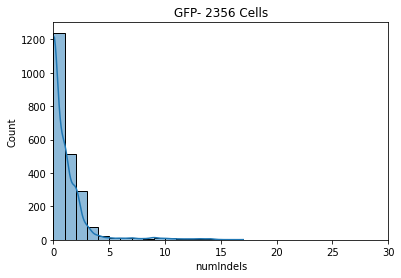

In [58]:
fig = plt.figure()
ax = sns.histplot(data = TLS1.obs[TLS1.obs['GFP_pos'] == 0], x = 'numIndels', binwidth = 1, kde = True, fill = True)
ax.set_xlim(0, 30)
ax.grid(False)
ax.set_title('GFP- {} Cells'.format(len(TLS1.obs[TLS1.obs['GFP_pos'] == 0])))
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/n_Indels_GFP-_hist.pdf', dpi = 300)
plt.show()
plt.close()

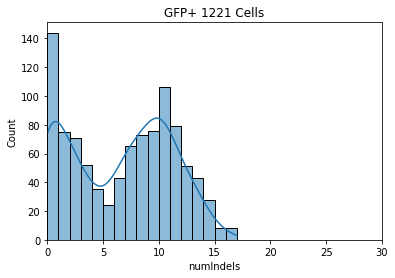

In [59]:
fig = plt.figure()
ax = sns.histplot(data = TLS1.obs[TLS1.obs['GFP_pos'] == 1], x = 'numIndels', binwidth = 1, kde = True, fill = True)
ax.set_xlim(0, 30)
ax.grid(False)
ax.set_title('GFP+ {} Cells'.format(len(TLS1.obs[TLS1.obs['GFP_pos'] == 1])))
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/n_Indels_GFP+_hist.pdf', dpi = 300)
plt.show()
plt.close()

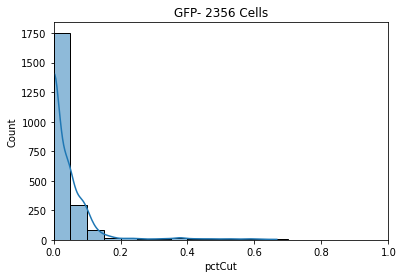

In [60]:
fig = plt.figure()
ax = sns.histplot(data = TLS1.obs[TLS1.obs['GFP_pos'] == 0], x = 'pctCut', binwidth = 0.05, kde = True)
ax.set_xlim(0, 1)
ax.grid(False)
ax.set_title('GFP- {} Cells'.format(len(TLS1.obs[TLS1.obs['GFP_pos'] == 0])))
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/PctCut_GFP-_hist.pdf', dpi = 300)
plt.show()
plt.close()

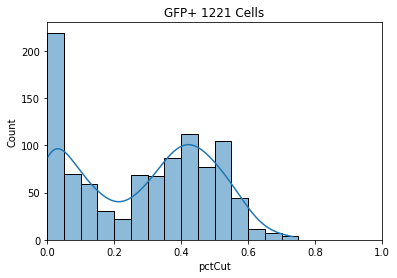

In [61]:
fig = plt.figure()
ax = sns.histplot(data = TLS1.obs[TLS1.obs['GFP_pos'] == 1], x = 'pctCut', binwidth = 0.05, kde = True)
ax.set_xlim(0, 1)
ax.grid(False)
ax.set_title('GFP+ {} Cells'.format(len(TLS1.obs[TLS1.obs['GFP_pos'] == 1])))
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/PctCut_GFP+_hist.pdf', dpi = 300)
plt.show()
plt.close()

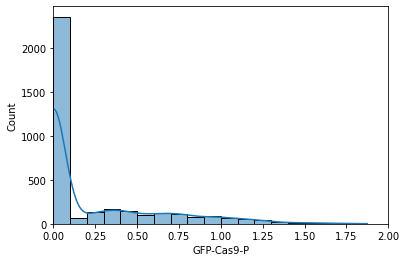

In [63]:
fig = plt.figure()
ax = sns.histplot(GFP_expr, kde = True, binwidth = 0.1, legend = False)
ax.set_xlabel('GFP-Cas9-P')
ax.set_xlim(0, 2)
plt.grid(False)
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/GFP-Cas9-P_hist.pdf', dpi = 300)
plt.show()
plt.close()

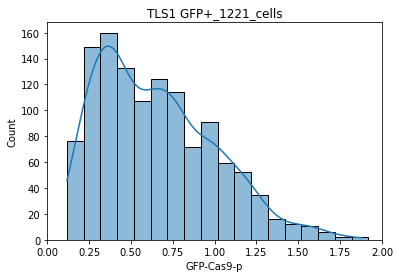

In [65]:
# Plot the histogram of GFP expression in GFP + cells
fig = plt.figure()
ax = sns.histplot(data = TLS1.obs[TLS1.obs['GFP_pos'] == 1], x = 'GFP-Cas9-p', binwidth = 0.1, kde = True)
ax.set_xlim(0, 2)
ax.grid(False)
ax.set_title('TLS1 GFP+_' + str(len(TLS1.obs[TLS1.obs['GFP_pos'] == 1]['GFP-Cas9-p'])) + '_cells')
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/GFP-Cas9-P_GFP+_hist.pdf', dpi = 300)
plt.show()
plt.close()

# Composition of GFP+ and GFP- cells

In [71]:
TLS1_GFPpos_cell_state_freq = {}
TLS1_GFPneg_cell_state_freq = {}

In [72]:
GFPpos = TLS1.obs[TLS1.obs['GFP_pos'] == 1]
GFPneg = TLS1.obs[TLS1.obs['GFP_pos'] == 0]

In [73]:
for cell_state in colorDict.keys():
    TLS1_GFPpos_cell_state_freq[cell_state] = 100 * len(GFPpos[GFPpos['cell_state'] == cell_state]) / len(GFPpos['cell_state'])
    TLS1_GFPneg_cell_state_freq[cell_state] = 100 * len(GFPneg[GFPneg['cell_state'] == cell_state]) / len(GFPneg['cell_state'])

In [75]:
cell_percents = pd.DataFrame.from_dict([TLS1_GFPpos_cell_state_freq, TLS1_GFPneg_cell_state_freq])
cell_percents = cell_percents.rename(index = {0: "GFP+", 1: "GFP-"})

In [76]:
colors = []
for color in cell_percents.columns:
    colors.append(colorDict[color])

In [78]:
cell_percents.plot(kind='bar', use_index = True, stacked=True, color = colors, grid = False)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('TLS1 GFP +/- Composition')
plt.ylabel('% cells/cluster')
plt.tight_layout()
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/TLS_1_GFP+_vs_GFP-_Composition.pdf', dpi = 300)
#plt.show()
plt.close()

# Cell proportions of cells for GFP+/- and pctCut +/-

In [66]:
# % cut by cell cluster ID
cellCounts = TLS1.obs["cell_state"].value_counts()

x1 = TLS1.obs.groupby(["cell_state", "GFP_pos"]).agg({"pctCut_pos": "count"}).reset_index()
x1.rename(columns = {"pctCut_pos": "n_count"}, inplace = True)

b1 = x1[x1["GFP_pos"] == 1].reset_index(drop = True)
cellStateList = b1["cell_state"].tolist() #cellStateList
b1.set_index("cell_state",inplace = True)
b1["prop"] = b1["n_count"] / cellCounts[cellStateList]

b2 = x1[x1["GFP_pos"] == 0].reset_index(drop = True)
b2.set_index("cell_state", inplace = True)
b2["prop"] = b2["n_count"] / cellCounts[cellStateList]

x2 = TLS1.obs.groupby(["cell_state", "pctCut_pos"]).agg({"GFP_pos": "count"}).reset_index()
x2.rename(columns={"GFP_pos": "n_count"}, inplace = True)

p1 = x2[x2["pctCut_pos"] == 1].reset_index(drop = True)
p1.set_index("cell_state", inplace = True)
p1["prop"] = p1["n_count"] / cellCounts[cellStateList]

p2 = x2[x2["pctCut_pos"] == 0].reset_index(drop = True)
p2.set_index("cell_state", inplace = True)
p2["prop"] = p2["n_count"] / cellCounts[cellStateList]

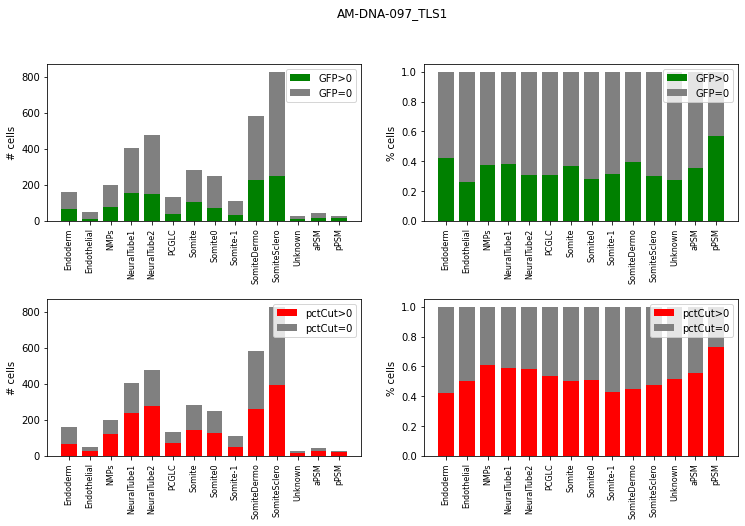

In [70]:
h = plt.figure(figsize=(12,8))

ax = plt.subplot(2,2,1)
plt.bar(np.arange(len(cellStateList)),b1["n_count"],0.75,label="GFP>0",color="Green")
plt.bar(np.arange(len(cellStateList)),b2["n_count"],0.75,bottom=b1["n_count"],label="GFP=0",color="Grey")
x1 = plt.xticks(np.arange(len(cellStateList)), cellStateList, rotation=90,fontsize=8)
plt.ylabel("# cells")
plt.grid(False)
plt.legend(loc="upper right")

ax = plt.subplot(2,2,2)
plt.bar(np.arange(len(cellStateList)),b1["prop"],0.75,label="GFP>0",color="Green")
plt.bar(np.arange(len(cellStateList)),b2["prop"],0.75,bottom=b1["prop"],label="GFP=0",color="Grey")
x1 = plt.xticks(np.arange(len(cellStateList)), cellStateList, rotation=90,fontsize=8)
plt.ylabel("% cells")
plt.grid(False)
plt.legend(loc="upper right")

ax = plt.subplot(2,2,3)
plt.bar(np.arange(len(cellStateList)),p1["n_count"],0.75,label="pctCut>0",color="Red")
plt.bar(np.arange(len(cellStateList)),p2["n_count"],0.75,bottom=p1["n_count"],label="pctCut=0",color="Grey")
x1 = plt.xticks(np.arange(len(cellStateList)), cellStateList, rotation=90,fontsize=8)
plt.ylabel("# cells")
plt.grid(False)
plt.legend(loc="upper right")

ax = plt.subplot(2,2,4)
plt.bar(np.arange(len(cellStateList)),p1["prop"],0.75,label="pctCut>0",color="Red")
plt.bar(np.arange(len(cellStateList)),p2["prop"],0.75,bottom=p1["prop"],label="pctCut=0",color="Grey")
x1 = plt.xticks(np.arange(len(cellStateList)), cellStateList, rotation=90,fontsize=8)
plt.ylabel("% cells")
plt.grid(False)
plt.legend(loc="upper right")

plt.suptitle('AM-DNA-097_TLS1')
plt.subplots_adjust(left=0.1,bottom=0.2,hspace=0.5)
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/GFP_pctCut_by_cellType.pdf', dpi = 900)
plt.show()
plt.close()

In [80]:
for cell_state in colorDict.keys():
    plt.scatter(b1.loc[cell_state]['prop'], p1.loc[cell_state]['prop'], color = colorDict[cell_state])
    
plt.grid(False)
plt.xlim(0, 0.6)
plt.ylim(0.2, 0.8)
plt.xlabel('Proportion GFP+')
plt.ylabel('Proportion Cut')
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/Cut_vs_GFP_by_Cellstate.pdf', dpi = 900)
#plt.show()
plt.close()

In [ ]:
# boxplot of pctCut in GFP+ and GFP-
fig = plt.figure()
ax = sns.boxplot(data = TLS1.obs, x = 'GFP_pos', y = 'pctCut')
ax.set_ylim(0, 1)
ax.set_ylabel('% Cut TS/cell')
ax.grid(False)
ax.set_title('pctCut')
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/PctCut_GFP+_vs_GFP-_boxplot.pdf', dpi = 900)
plt.show()
plt.close()

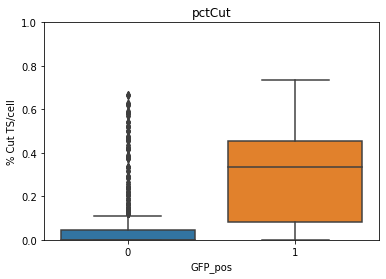

In [81]:
# boxplot of pctCut in GFP+ and GFP-
fig = plt.figure()
ax = sns.boxplot(data = TLS1.obs, x = 'GFP_pos', y = 'pctCut')
ax.set_ylim(0, 1)
ax.set_ylabel('% Cut TS/cell')
ax.grid(False)
ax.set_title('pctCut')
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/PctCut_GFP+_vs_GFP-_boxplot.pdf', dpi = 900)
plt.show()
plt.close()

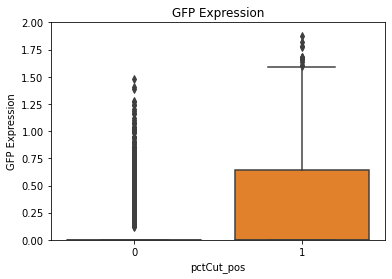

In [82]:
# boxplot of pctCut in GFP+ and GFP-
fig = plt.figure()
ax = sns.boxplot(data = TLS1.obs, x = 'pctCut_pos', y = 'GFP-Cas9-p')
ax.set_ylim(0, 2)
ax.set_ylabel('GFP Expression')
ax.grid(False)
ax.set_title('GFP Expression')
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/3_lineage_stats/GFP_Cut_vs_Uncut_boxplot.pdf', dpi = 900)
plt.show()
plt.close()